This notebook is designed to be run after another notebook $load_data_w_EDA.ipynb$, which was included in this submission.

# Hailey Weinschenk - BrainStation Capstone Notebook 3 - Multiclass Classification

In this notebook, we expand on our classification problem. Instead of training model(s) to predict a card being red or black, we aim to achieve suit classification. There are 4 suits in the French Deck: Spades, Clubs, Hearts, and Diamonds.

First, we will import all the necessary libraries. As with the binary classification notebook, we need to ensure the presence of *preprocess.py* in the same directory during runtime.

In [1]:
from preprocess import preprocess
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import os.path

In [2]:
if( os.path.exists('full_preprocessedML.csv')):
    df_chunk = pd.read_csv('full_preprocessedML.csv',index_col=0,iterator=True,chunksize=250)
    df = pd.concat(df_chunk)
else:
   print('Please run load_data_w_EDA.ipynb then rerun this notebook.')

## RANDOM FOREST FOR MULTICLASS CLASSIFICATION

Firstly, we define our features and target, then perform a train-test split. Our features remain the same (pixel data) but our new target is the suit of the card. These suits are encoded as 
 - Diamonds = 0
 - Clubs = 1
 - Hearts = 2
 - Spades = 3
 - Joker = 4

In [3]:
from sklearn.model_selection import train_test_split
X = df.iloc[:,2:-5] # set our features to be only the pixels
y = df['suit_num'] # target is the suit number
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = .2,stratify=y)
X_train/=255
X_test/=255 

The `n_estimators` hyperparameter of the random forest controls how many subtrees are contained within the model. This feature of Random Forest (RF) is significant as taking some aggregation of the scores of these individual models prevents overfitting typical of single decision trees. 

We want to include a validation, or dev, set for this tuning in order to prevent leakage. In the next cell, we will take a validation set to be a subset of our training data. Next, a RF will be fit on the validation data, a range of estimators are tested and the scores will be plotted. Two of these scores are included: the average score of each subtree, and the score of the RF. The range steps due to runtime limitations.

In [5]:
from sklearn.ensemble import RandomForestClassifier
X_t_val,X_val,y_t_val,y_val = train_test_split(X_train,y_train,test_size = .2)
decision_tree_scores= []
performance_test_avg_of_estimators = []
performance_test_random_forest= []
for i in np.arange(50,150,10):
    print(f'Running...Iteration with the number of estimators in the Random Forest as {i}.',end="\r")
    my_random_forest = RandomForestClassifier(n_estimators=i)
    my_random_forest.fit(X_t_val, y_t_val)
 
 
    for sub_tree in my_random_forest.estimators_:
        decision_tree_scores.append(sub_tree.score(X_val, y_val))
    performance_test_avg_of_estimators.append(np.mean(decision_tree_scores))
    performance_test_random_forest.append(my_random_forest.score(X_val,y_val))

In [6]:
print(f'The max Random Forest accuracy is:  {max(performance_test_random_forest)} with number of subtrees {50+10*performance_test_random_forest.index(max(performance_test_random_forest))}')

The max Random Forest accuracy is:  0.9478458049886621 with number of subtrees 140


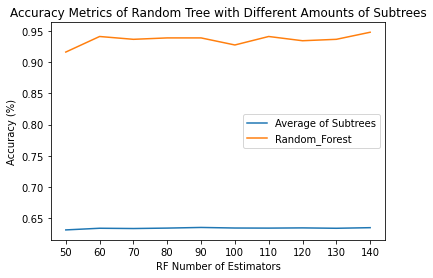

In [7]:
plt.plot(performance_test_avg_of_estimators,label = 'Average of Subtrees')
plt.plot(performance_test_random_forest,label = 'Random_Forest')
plt.title('Accuracy Metrics of Random Tree with Different Amounts of Subtrees')
plt.xlabel('RF Number of Estimators')
plt.ylabel('Accuracy (%)')
plt.xticks(ticks = np.arange(0,10),labels = np.arange(50,150,10))
plt.legend()
plt.show()

We can see that the RF accuracy is way higher than the simple mean of the subtrees accuracy. This is due to the subtrees overfitting. So therefore, the accuracy on each subtree will be very high for training data, but comparatively low for testing data it hasn't seen before. We can highlight this by viewing the scores for the first subtree below: 

In [8]:
first_subtree = my_random_forest.estimators_[0]
print(type(first_subtree)) # of type DecisionTreeClassifier (single Tree)
print(f'Training Score: {first_subtree.score(X_t_val,y_t_val)}') # our training set is the original training set, after the train-val split
print(f'Test Score: {first_subtree.score(X_val,y_val)}') # val set is analogous to our test set here

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
Training Score: 0.8689733408961997
Test Score: 0.6462585034013606


This gap is large. There is clear overfitting present. 

RF accuracy is obtained by taking a majority 'vote' of the subtrees rather than their average. This de-emphazises the overfitting of each particular subtree.

So these initial results of these RFs are a lot higher than our logisitc regression models were. Moreover, it is important to note that we are dealing with multiclass classification with 4 classes, versus our binary classification in that model. For that reason, a higher accuracy is even more impressive!

Next, we can implement the same grid search with the two key Random Forest parameters in attempts to maximize accuracy. This includes `n_estimators` as well as `max_depth` which controls the maximum number of levels of each of the estimators. However, due to limitations due to the size of the DataFrame as well as the incredibly dense models, we cannot gridsearch over multiple hyperparameters of the Random Forest without a runtime of hours. Rather, the plot above shows that increases in number of subtrees is negligible to the accuracy, we can define this to be modest 90 then gridsearch only over the depth hyperparameters. 

In [9]:
from sklearn.model_selection import GridSearchCV 
grid = {'max_depth' : np.arange(8,13)}
RFC = RandomForestClassifier(n_estimators = 90)
forestCV = GridSearchCV(RFC, grid, cv= 5)
forestCV.fit(X_train, y_train)

forestCV.best_params_,forestCV.best_score_

({'max_depth': 12}, 0.9364687693259123)

For a bit of a sanity check, let's print out the first 5 cards, with their suit classification. Our encoding from the preprocessing stage was: 
 - Diamonds = 0
 - Clubs = 1
 - Hearts = 2
 - Spades = 3
 - Joker = 4

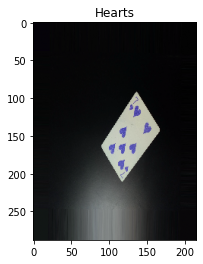

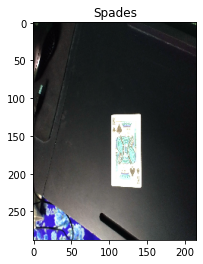

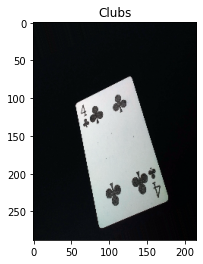

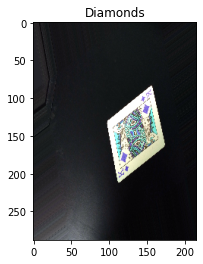

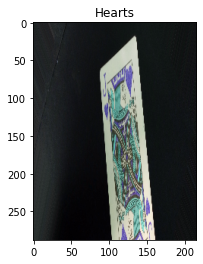

In [10]:
for i in range (0,5):
    prediction = int(my_random_forest.predict([X_test.iloc[i,:]]))
    if(prediction == 0):
        suit = 'Diamonds'
    if(prediction == 1):
        suit = 'Clubs' 
    if(prediction == 2):
        suit = 'Hearts'
    if(prediction == 3):
        suit = 'Spades'
    if(prediction == 4):
        suit = 'Joker'
    plt.title(suit)
    plt.imshow(np.array(X_test.iloc[i,:]).reshape(288,216,3))
    plt.show()

So RF proved to be an effective model for this classification problem!

## XGBOOST

For illustrative purposes, and to show what can be done if accuracy with normal tree-based models isn't sufficient, we will look at XGBoost.

XGBoost is a powerful, open-source library for a myriad of languages, that provides a framework for gradient boosting. Like Random Forest, this is another ensemble based model that often involves decision trees. But in boosting, the output of weak predictors is weighted by how accurate and overfitting they are. This is fundamentally different than random forest. 

> "[XGBoost] has gained much popularity and attention recently as the algorithm of choice for many winning teams of machine learning competitions". [wikipedia](https://en.wikipedia.org/wiki/XGBoost)


Due to the computational complexity of this algorithm, it pushes a processor to the limit. This is a different issue than RAM issues from earlier, but nonetheless we will illustrate with the same target, but on a subset of our images.

In [11]:
X = X.astype(int).iloc[::2,:] # convert types to int for XGBoost
y = df['suit_num'].iloc[::2] # and take subset

In [12]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = .2)

In [13]:
from xgboost import XGBClassifier #import XGBoost
#I
XGB_model = XGBClassifier() #alternatively: XGBClassifier(tree_method = "gpu_hist")
                            # runs XGBoost on a GPU, but that is omitted for compatibility purposes
#F
XGB_model.fit(X_train, y_train)
#S
print(f"XGBoost score: {XGB_model.score(X_test, y_test)}")

[22:31:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost score: 0.9202898550724637


So our accuracy was similar to a Random Forest! Usually, XGBoost outperforms a Random Forest, but not in this case, possibly due to operating on only half the data. 